In [166]:
import numpy as np
import tensorflow as tf
import struct
import matplotlib.pyplot as plt

In [167]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [168]:
#loading the dataset 
training_data = read_idx('/Users/Ronja/Downloads/TensorFlow_Introduction/TensorFlow_Introduction/MNIST/train-images.idx3-ubyte')

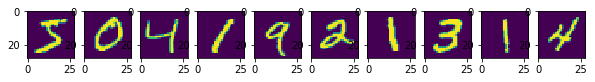

In [169]:
# displaying the first 10 training examples
fig, ax = plt.subplots(1,10,figsize=(10,10))
for i in range(10): ax[i].imshow(training_data[i])

# Creating the datasets

In [170]:
tf.reset_default_graph()

# get the data
# training_data is already loaded
training_labels = read_idx('/Users/Ronja/Downloads/TensorFlow_Introduction/TensorFlow_Introduction/MNIST/train-labels.idx1-ubyte')
validation_data = read_idx('/Users/Ronja/Downloads/TensorFlow_Introduction/TensorFlow_Introduction/MNIST/t10k-images.idx3-ubyte')
validation_labels = read_idx('/Users/Ronja/Downloads/TensorFlow_Introduction/TensorFlow_Introduction/MNIST/t10k-labels.idx1-ubyte')

# create the tensorflow dataset
training_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))

# define the batch size
training_batchsize = 128
validation_batchsize = 1000

# split the dataset into batches
training_dataset = training_dataset.batch(training_batchsize)
validation_dataset = validation_dataset.batch(validation_batchsize)

# shuffel the data (in each epoch)
training_dataset = training_dataset.shuffle(buffer_size=4, reshuffle_each_iteration=True)

## Creating an iterator


In [171]:
# create an iterator
iterator = tf.data.Iterator.from_structure(training_dataset.output_types, training_dataset.output_shapes)

# name operation that gives next batch
next_batch = iterator.get_next()

# initializer operations for training and validation dataset
training_initialize_iterator = iterator.make_initializer(training_dataset)
validation_initialize_iterator = iterator.make_initializer(validation_dataset)

# Building the model

## Formating the data


In [172]:
#get the batch 
input_data = next_batch[0]
labels = next_batch[1]

#make vector out of matrix input
input_data = tf.reshape(input_data,shape=[-1,784])
input_data = tf.cast(input_data, tf.float32)
###
#make a one hot vector out of labels
#original_training_labels = training_labels
#training_labels = tf.cast(training_labels, tf.int32)
#training_labels = tf.one_hot(training_labels, 10)
#original_validation_labels = training_labels
#validation_labels = tf.cast(training_labels, tf.int32)
#validation_labels = tf.one_hot(validation_labels, 10)
labels = tf.cast(labels, tf.int32)
one_hot_labels = tf.one_hot(labels, 10)

## Defining the forward step

In [173]:
#defining the weights
initial_weights = tf.random_normal([784, 10],mean=0.0,stddev=2e-06)
weights = tf.Variable(initial_weights, dtype=tf.float32)
#defining the biases
initial_biases = tf.zeros(10)
biases = tf.Variable(initial_biases, dtype=tf.float32)
#defining the drive
logits = input_data @ weights + biases
print(one_hot_labels.shape)
#defining the output
output = tf.nn.softmax(logits)

(?, 10)


## Metrics

In [174]:
#getting loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_labels, logits=logits)
loss = tf.reduce_mean(cross_entropy)
#defining the accuracy

## Optimizer

In [153]:
#defining the learning rate
learning_rate = 1e-5

#defining the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

#define training step
training_step = optimizer.minimize(loss)

## Summaries

In [154]:
# adding summaries for loss and accuracy
tf.summary.scalar('loss', loss)
#tf.summary.scalar('accuracy', accuracy)

#merging summaries
merged_summaries = tf.summary.merge_all()
#making file writers for training and validation metrics
train_writer = tf.summary.FileWriter('./summaries/train/')
validation_writer = tf.summary.FileWriter('./summaries/validation/', flush_secs =2)

# Training

In [155]:
#defining the epochs
epochs = 5
#starting Tensorflow session
with tf.Session() as sess:
    #inizializing variables
    sess.run(tf.global_variables_initializer())
    #making global step counter
    global_step = 0
    #defining the epoch loop (runs through training and validation epoch number of times)
    for _ in range(epochs):
        #initializing iterator with training data for this epoch
        sess.run(training_initialize_iterator)
        #going through all batches once
        while True:
            try:
                #running training step and reading out summary
                _, summary  = sess.run((training_step, merged_summaries))
                #saving the summary
                train_writer.add_summary(summary, global_step)
                #incrementing global step
                global_step = global_step + 1
            except tf.errors.OutOfRangeError:
                break
        
        #Validation part
        #initializing the iterator
        sess.run(validation_initialize_iterator)
        #reading out summary
        summary = sess.run((merged_summaries))
        #saving summary
        validation_writer.add_summary(summary, global_step)

InvalidArgumentError: logits and labels must be broadcastable: logits_size=[128,10] labels_size=[1,128]
	 [[{{node softmax_cross_entropy_with_logits}} = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](add, softmax_cross_entropy_with_logits/Reshape_1)]]

Caused by op 'softmax_cross_entropy_with_logits', defined at:
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-90-e6c99ac6a73f>", line 2, in <module>
    losses = tf.nn.softmax_cross_entropy_with_logits_v2(labels = labels, logits = logits)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1888, in softmax_cross_entropy_with_logits_v2
    precise_logits, labels, name=name)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 7210, in softmax_cross_entropy_with_logits
    name=name)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/Users/Ronja/anaconda3/envs/tfcourse/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): logits and labels must be broadcastable: logits_size=[128,10] labels_size=[1,128]
	 [[{{node softmax_cross_entropy_with_logits}} = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](add, softmax_cross_entropy_with_logits/Reshape_1)]]
